New sstepss


In [ ]:
# Cell 1: Configuration
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numba
import warnings
import pywt
import math
import time
from joblib import Parallel, delayed
import matplotlib.colors as mcolors
import networkx as nx
import community as community_louvain
import json
import os

# --- File Configuration ---
#CONTROL_FILENAME = "data/328/danaRest25.tsv"
#ACTIVE_FILENAME = "data/328/danaGlut.tsv"
CONFIG_FILE = 'config.json'
REPORT_DIR = 'mea_analysis_report'


SAMPLING_RATE_HZ = 20000.0
HEADERS_PRIMARY = [
    "t", "Ch 21", "Ch 31", "Ch 41", "Ch 51", "Ch 61", "Ch 71", "Ch 12", "Ch 22", "Ch 32", "Ch 42", "Ch 52", "Ch 62", "Ch 72", "Ch 82",
    "Ch 13", "Ch 23", "Ch 33", "Ch 43", "Ch 53", "Ch 63", "Ch 73", "Ch 83", "Ch 14", "Ch 24", "Ch 34", "Ch 44", "Ch 54", "Ch 64", "Ch 74", "Ch 84",
    "Ch 15", "Ch 25", "Ch 35", "Ch 45", "Ch 55", "Ch 65", "Ch 75", "Ch 85", "Ch 16", "Ch 26", "Ch 36", "Ch 46", "Ch 56", "Ch 66", "Ch 76", "Ch 86",
    "Ch 17", "Ch 27", "Ch 37", "Ch 47", "Ch 57", "Ch 67", "Ch 77", "Ch 87", "Ch 28", "Ch 38", "Ch 48", "Ch 58", "Ch 68", "Ch 78"
]
CHANNEL_NAMES_DATA = HEADERS_PRIMARY[1:]
USE_FLOAT32 = True

print("Configuration and base imports defined.")

# --- Helper ---

def save_params(params_dict, filepath):
    """Saves a dictionary of parameters to a JSON file."""
    print(f"Saving configuration to {filepath}...")
    with open(filepath, 'w') as f:
        json.dump(params_dict, f, indent=4)

def load_params(filepath):
    """Loads a dictionary of parameters from a JSON file."""
    print(f"Loading configuration from {filepath}...")
    with open(filepath, 'r') as f:
        return json.load(f)

def load_mea_data(filepath, column_names, use_float32=True):
    print(f"Attempting to load data from: {filepath}")
    dtype_map = {name: (np.float32 if use_float32 else np.float64) for name in column_names}
    try:
        df = pd.read_csv(filepath, sep='\t', header=None, names=column_names, dtype=dtype_map, engine='c')
        print(f"Data loaded successfully: {df.shape}"); return df
    except Exception as e:
        print(f"Error during file loading: {e}"); return pd.DataFrame()

@numba.njit
def detect_peaks_numba_two_sided(voltages_arr, pos_threshold, neg_threshold, refractory_period_samples):
    neg_crossings, = np.where(voltages_arr < neg_threshold)
    pos_crossings, = np.where(voltages_arr > pos_threshold)
    neg_spike_indices = numba.typed.List();
    if len(neg_crossings) > 0:
        i = 0
        while i < len(neg_crossings):
            j = i
            while j + 1 < len(neg_crossings) and neg_crossings[j+1] == neg_crossings[j] + 1: j += 1
            search_window = voltages_arr[neg_crossings[i] : neg_crossings[j]+1]
            neg_spike_indices.append(neg_crossings[i] + np.argmin(search_window)); i = j + 1
    pos_spike_indices = numba.typed.List()
    if len(pos_crossings) > 0:
        i = 0
        while i < len(pos_crossings):
            j = i
            while j + 1 < len(pos_crossings) and pos_crossings[j+1] == pos_crossings[j] + 1: j += 1
            search_window = voltages_arr[pos_crossings[i] : pos_crossings[j]+1]
            pos_spike_indices.append(pos_crossings[i] + np.argmax(search_window)); i = j + 1
    total_spikes = len(neg_spike_indices) + len(pos_spike_indices)
    if total_spikes == 0: return np.empty(0, dtype=np.int64)
    all_indices = np.empty(total_spikes, dtype=np.int64)
    for i in range(len(neg_spike_indices)): all_indices[i] = neg_spike_indices[i]
    for i in range(len(pos_spike_indices)): all_indices[len(neg_spike_indices) + i] = pos_spike_indices[i]
    all_indices.sort()
    if len(all_indices) < 2: return all_indices
    valid_spikes_list = numba.typed.List(); valid_spikes_list.append(all_indices[0]); last_spike_idx = all_indices[0]
    for i in range(1, len(all_indices)):
        current_spike_idx = all_indices[i]
        if current_spike_idx > last_spike_idx + refractory_period_samples:
            valid_spikes_list.append(current_spike_idx); last_spike_idx = current_spike_idx
    final_indices = np.empty(len(valid_spikes_list), dtype=np.int64)
    for k in range(len(valid_spikes_list)): final_indices[k] = valid_spikes_list[k]
    return final_indices

def detect_bursts(spike_times_ms, min_spikes, max_isi_ms, min_duration_ms):
    if len(spike_times_ms) < min_spikes: return []
    bursts = [];
    if len(spike_times_ms) < 2: return []
    current_burst = [spike_times_ms[0]]
    for i in range(1, len(spike_times_ms)):
        if spike_times_ms[i] - current_burst[-1] <= max_isi_ms:
            current_burst.append(spike_times_ms[i])
        else:
            if len(current_burst) >= min_spikes and (current_burst[-1] - current_burst[0]) >= min_duration_ms:
                bursts.append({'start_time_ms': current_burst[0], 'end_time_ms': current_burst[-1], 'duration_ms': current_burst[-1] - current_burst[0], 'num_spikes': len(current_burst), 'spike_times_ms': np.array(current_burst)})
            current_burst = [spike_times_ms[i]]
    if len(current_burst) >= min_spikes and (current_burst[-1] - current_burst[0]) >= min_duration_ms:
        bursts.append({'start_time_ms': current_burst[0], 'end_time_ms': current_burst[-1], 'duration_ms': current_burst[-1] - current_burst[0], 'num_spikes': len(current_burst), 'spike_times_ms': np.array(current_burst)})
    return bursts

@numba.njit
def calculate_cross_corr(spike_times1, spike_times2, window_ms, bin_ms):
    bins = np.arange(-window_ms, window_ms + bin_ms, bin_ms)
    n_bins = len(bins) - 1
    corr = np.zeros(n_bins, dtype=np.int32)
    for t1 in spike_times1:
        start_idx = np.searchsorted(spike_times2, t1 - window_ms, side='left')
        end_idx = np.searchsorted(spike_times2, t1 + window_ms, side='right')
        diffs = spike_times2[start_idx:end_idx] - t1
        if len(diffs) > 0:
            hist, _ = np.histogram(diffs, bins=bins)
            corr += hist
    return corr, bins

def _parse_spike_indices(index_vector, sf_khz, wid_ms):
    if not np.any(index_vector): return np.array([], dtype=int)
    refractory_period_samples = int(1.5 * wid_ms[1] * sf_khz); merge_period_samples = int(np.mean(wid_ms) * sf_khz)
    diff_vec = np.diff(index_vector.astype(int), prepend=0, append=0); starts = np.where(diff_vec == 1)[0]; ends = np.where(diff_vec == -1)[0] - 1
    if len(starts) == 0: return np.array([], dtype=int)
    spike_candidates = sorted(list(set([int(np.mean([s, e])) for s, e in zip(starts, ends)])))
    if len(spike_candidates) < 2: return np.array(spike_candidates, dtype=int)
    final_spikes = []; i = 0
    while i < len(spike_candidates):
        j = i + 1
        while j < len(spike_candidates) and (spike_candidates[j] - spike_candidates[i]) <= merge_period_samples: j += 1
        merged_spike = int(np.mean(spike_candidates[i:j]))
        if not final_spikes or (merged_spike - final_spikes[-1]) >= refractory_period_samples: final_spikes.append(merged_spike)
        i = j
    return np.array(final_spikes, dtype=int)

def detect_spikes_wavelet(signal, sf, wid, ns, option, l_param, wname, wavelet_threshold_factor):
    sf_khz = sf / 1000.0; signal = signal - np.mean(signal); nt = len(signal)
    min_scale = wid[0] * sf_khz; max_scale = wid[1] * sf_khz
    scales = np.linspace(min_scale, max_scale, ns)
    if np.any(scales <= 1): scales[scales <= 1] = 1.1; warnings.warn(f"Some scales were <= 1 and were adjusted.")
    coeffs, _ = pywt.cwt(signal, scales, wname, sampling_period=1.0)
    l_max = 36.7368; l_val = l_param * l_max
    spike_indicator = np.zeros(nt, dtype=bool)
    for i in range(ns):
        step = int(np.round(scales[i])) if np.round(scales[i]) > 0 else 1
        n_coeffs = len(coeffs[i, :]); sigma_j = np.median(np.abs(coeffs[i, ::step])) / 0.6745
        th_j = sigma_j * np.sqrt(2 * np.log(nt)); index = np.where(np.abs(coeffs[i, :]) > th_j)[0]
        statistical_threshold = 0
        if len(index) == 0 and option == 'l': mj = th_j; ps = 1 / nt; pn = 1 - ps
        elif len(index) > 0: mj = np.mean(np.abs(coeffs[i, index])); ps = len(index) / nt; pn = 1 - ps
        if 'ps' in locals() and ps > 0 and (1 - ps) > 0 and 'mj' in locals() and mj > 0: statistical_threshold = mj/2 + (sigma_j**2 / mj) * (l_val + np.log((1-ps) / ps))
        adaptive_direct_threshold = wavelet_threshold_factor * sigma_j * math.sqrt(2 * math.log(n_coeffs))
        final_threshold = min(statistical_threshold, adaptive_direct_threshold) if statistical_threshold > 0 else adaptive_direct_threshold
        if final_threshold > 0: spike_indicator[np.where(np.abs(coeffs[i, :]) > final_threshold)[0]] = True
    return _parse_spike_indices(spike_indicator, sf_khz, wid)

def save_single_analysis_results(analysis_object, output_dir):
    """
    Saves the key machine-readable results from a single MEAAnalysis run.
    - Per-channel summary data is saved as a CSV.
    - Global network metrics are saved as a JSON.

    Args:
        analysis_object (MEAAnalysis): The completed analysis object.
        output_dir (str): The directory to save the files in.
    """
    # Extract the base name from the input file path, e.g., "faxRest2" from "data/328/faxRest2.tsv"
    base_name = os.path.splitext(os.path.basename(analysis_object.filepath))[0]
    
    print(f"\n--- Saving machine-readable data for '{base_name}' ---")
    
    for method in analysis_object.summary_df.keys():
        
        summary_df = analysis_object.summary_df.get(method)
        if summary_df is not None and not summary_df.empty:
            csv_filename = f"{base_name}_summary_{method}.csv"
            csv_path = os.path.join(output_dir, csv_filename)
            summary_df.to_csv(csv_path)
            
        network_globals = analysis_object.network_events.get(method)
        if network_globals:
            json_filename = f"{base_name}_globals_{method}.json"
            json_path = os.path.join(output_dir, json_filename)
            network_globals['sample_id'] = base_name 
            with open(json_path, 'w') as f:
                json.dump(network_globals, f, indent=4)

            
    print(f"--- Data saving for '{base_name}' complete. ---")
    
print("Helper functions are defined and ready.")



Configuration and base imports defined.
Helper functions are defined and ready.


In [ ]:
# Cell 2: High-Level Logic and MEAAnalysis Class

def _process_channel(channel_name, params, raw_data_df):
    """Worker function for parallel processing (your version is good)."""
    voltages = raw_data_df[channel_name].values; fs = params['sampling_rate_hz']
    chunk_duration_s = params.get('mad_chunk_duration_s', 5.0)
    chunk_size_samples = int(chunk_duration_s * fs); n_total_samples = len(voltages)
    all_chunk_indices = []
    for i in range(0, n_total_samples, chunk_size_samples):
        start_idx = i; end_idx = min(i + chunk_size_samples, n_total_samples)
        voltages_chunk = voltages[start_idx:end_idx]
        chunk_indices = _process_chunk_mad(voltages_chunk, start_idx, fs, params['refractory_period_ms'], params['mad_threshold_factor'])
        if len(chunk_indices) > 0: all_chunk_indices.append(chunk_indices)
    mad_spike_indices = np.sort(np.concatenate(all_chunk_indices)) if all_chunk_indices else np.empty(0, dtype=np.int64)
    wavelet_spike_indices = detect_spikes_wavelet(voltages, fs, wid=params['wavelet_wid_ms'], ns=params['wavelet_ns'], option=params.get('wavelet_option', 'l'), wname=params['wavelet_wname'], l_param=params['wavelet_l_param'], wavelet_threshold_factor=params['wavelet_threshold_factor'])
    return channel_name, {'mad': mad_spike_indices, 'wavelet': wavelet_spike_indices}

@numba.njit
def _process_chunk_mad(voltages_chunk, start_sample_index, fs, refractory_period_ms, mad_threshold_factor):
    """Numba-optimized MAD worker (your version is good)."""
    n_samples_chunk = len(voltages_chunk)
    if n_samples_chunk == 0: return np.empty(0, dtype=np.int64)
    median_v = np.median(voltages_chunk); mad_v = np.median(np.abs(voltages_chunk - median_v))
    if mad_v > 0: sigma_noise_mad = mad_v * 1.4826; threshold_magnitude = mad_threshold_factor * sigma_noise_mad * math.sqrt(2 * math.log(n_samples_chunk)); pos_threshold = threshold_magnitude; neg_threshold = -threshold_magnitude
    else: pos_threshold = 1e9; neg_threshold = -1e9
    refractory_samples = int(refractory_period_ms / (1000.0 / fs))
    relative_spike_indices = detect_peaks_numba_two_sided(voltages_chunk, pos_threshold, neg_threshold, refractory_samples)
    return relative_spike_indices + start_sample_index if len(relative_spike_indices) > 0 else np.empty(0, dtype=np.int64)


class MEAAnalysis:
    def __init__(self, filepath, sample_name, params):
        self.filepath = filepath
        self.sample_name = sample_name
        self.params = params
        self.raw_data_df = pd.DataFrame()
        # Dictionaries to hold results for each method
        self.spike_results = {}
        self.burst_results = {}
        self.network_events = {}
        self.connectivity_matrix = {}
        self.summary_df = {}
        self.total_duration_s = 0

        # Initialize dictionaries for all specified methods
        for method in self.params.get('methods_to_run', ['wavelet']):
            self.spike_results[method] = {}
            self.burst_results[method] = {}
            self.network_events[method] = {}
            self.connectivity_matrix[method] = pd.DataFrame()
            self.summary_df[method] = pd.DataFrame()

    def run_analysis(self, preloaded_df=None, analyze_network=True, analyze_connectivity=True):
        print(f"\n{'='*20} Starting Analysis for '{self.sample_name}' {'='*20}")
        start_time = time.time()
        
        self.raw_data_df = preloaded_df if preloaded_df is not None else load_mea_data(self.filepath, HEADERS_PRIMARY, USE_FLOAT32)
        if self.raw_data_df.empty: print(f"Stopping analysis for {self.sample_name}."); return
        self.total_duration_s = (self.raw_data_df['t'].iloc[-1] - self.raw_data_df['t'].iloc[0]) / 1000.0 if len(self.raw_data_df) > 1 else 0

        print("--- Running Parallel Spike Detection ---")
        results = Parallel(n_jobs=-1, backend='loky')(delayed(_process_channel)(ch, self.params, self.raw_data_df) for ch in CHANNEL_NAMES_DATA)
        all_spike_indices = {res[0]: res[1] for res in results}
        
        for method in self.params.get('methods_to_run', ['wavelet']):
            print(f"\n--- Post-processing for '{method.upper()}' method ---")
            for ch in CHANNEL_NAMES_DATA:
                spike_indices = all_spike_indices[ch][method]
                self.spike_results[method][ch] = self._get_spike_properties(spike_indices, ch)
                self.burst_results[method][ch] = self._get_burst_properties(self.spike_results[method][ch])
            
            self._create_initial_summary_table(method)
            
            if analyze_network: self.detect_network_events(method)
            if analyze_connectivity:
                self.calculate_connectivity_matrix(method)
                self._analyze_network_properties(method)
        
        print(f"\n--- Analysis for '{self.sample_name}' finished in {time.time() - start_time:.2f} seconds ---")


    def _analyze_network_properties(self, method):
        """
        Calculates network graph metrics.
        CORRECTED: Now performs community detection only on the active sub-network.
        UPDATED: Includes call to Node Cartography calculation.
        """
        print(f"--- Analyzing Network Graph Properties for '{method.upper()}' ---")
        conn_matrix = self.connectivity_matrix[method]
        summary = self.summary_df[method]

        if conn_matrix.empty or conn_matrix.sum().sum() == 0:
            for col in ['Degree Centrality', 'Betweenness Centrality', 'Clustering Coeff', 'Eigenvector Centrality', 'Community ID', 'z_score', 'P_coeff', 'Node Role']:
                if col not in summary.columns: summary[col] = np.nan
            summary['Node Role'] = 'Inactive'
            return

        G = nx.from_pandas_adjacency(conn_matrix, create_using=nx.DiGraph())

        # Standard metrics are calculated on the full graph
        summary['Degree Centrality'] = summary.index.map(nx.degree_centrality(G).get).fillna(0)
        summary['Betweenness Centrality'] = summary.index.map(nx.betweenness_centrality(G, weight='weight', normalized=True).get).fillna(0)
        summary['Clustering Coeff'] = summary.index.map(nx.clustering(G, weight='weight').get).fillna(0)

        try:
            eigen_cen = nx.eigenvector_centrality(G, weight='weight', max_iter=1000)
            summary['Eigenvector Centrality'] = summary.index.map(eigen_cen.get).fillna(0)
            print("Eigenvector Centrality calculated successfully.")
        except nx.PowerIterationFailedConvergence:
            print("WARNING: Eigenvector Centrality did not converge. Filling with 0.")
            summary['Eigenvector Centrality'] = 0.0

        self.network_events[method]['density'] = nx.density(G)
        self.network_events[method]['avg_clustering_coeff'] = nx.average_clustering(G, weight='weight')
        print(f"Network density: {self.network_events[method]['density']:.4f}, Avg. clustering: {self.network_events[method]['avg_clustering_coeff']:.4f}")
        
        print("--- Detecting functional communities (Louvain on active sub-graph) ---")
        partition_full = {node: -1 for node in G.nodes()} # Default all to inactive
        modularity = np.nan
        try:
            active_nodes = [node for node, degree in G.degree(weight='weight') if degree > 0]
            if len(active_nodes) > 1:
                G_active = G.subgraph(active_nodes).to_undirected()
                partition_active = community_louvain.best_partition(G_active, weight='weight', random_state=42)
                partition_full.update(partition_active) # Update with active communities
                modularity = community_louvain.modularity(partition_active, G_active, weight='weight')
                num_communities = len(set(partition_active.values()))
                print(f"Found {num_communities} communities among {len(active_nodes)} active channels with modularity: {modularity:.4f}")
            else:
                print("Not enough active nodes for community detection. All channels marked as inactive.")
        except Exception as e:
            print(f"ERROR during community detection: {e}")
        
        self.network_events[method]['modularity'] = modularity
        summary['Community ID'] = summary.index.map(partition_full).fillna(-1).astype(int)

        self._calculate_node_cartography(G, partition_full, method)

        print("--- Analyzing for rich-club structure ---")
        is_normalized = True
        G_undirected = G.to_undirected()
        try:
            rc = nx.rich_club_coefficient(G_undirected, normalized=True, seed=42)
            print("Rich-club analysis complete (Normalized).")
        except nx.NetworkXAlgorithmError as e:
            if "Maximum number of swap attempts" in str(e):
                print(f"WARNING: Could not generate random network for normalization: {e}")
                print("Falling back to UN-NORMALIZED rich-club coefficient.")
                rc = nx.rich_club_coefficient(G_undirected, normalized=False)
                is_normalized = False
                print("Rich-club analysis complete (Un-normalized).")
            else: rc = {}
        except Exception as e: rc = {}
        self.network_events[method]['rich_club_coefficient'] = rc
        self.network_events[method]['rich_club_is_normalized'] = is_normalized

    def _get_spike_properties(self, spike_indices, channel_name):
        if len(spike_indices) == 0: return {'num_spikes': 0, 'avg_frequency_hz': 0, 'spike_times_ms': np.array([]), 'spike_amplitudes_uv': np.array([]), 'isi_ms': np.array([]), 'mean_isi_ms': np.nan, 'cv_isi': np.nan, 'mean_amplitude_uv': np.nan, 'median_amplitude_uv': np.nan, 'std_amplitude_uv': np.nan}
        voltages = self.raw_data_df[channel_name].values; spike_times = self.raw_data_df['t'].iloc[spike_indices].values
        spike_amplitudes = voltages[spike_indices]; num_spikes = len(spike_times)
        avg_freq = num_spikes / self.total_duration_s if self.total_duration_s > 0 else 0
        isi_ms = np.diff(spike_times) if num_spikes > 1 else np.array([])
        return {'num_spikes': num_spikes, 'avg_frequency_hz': avg_freq, 'spike_times_ms': spike_times, 'spike_amplitudes_uv': spike_amplitudes, 'isi_ms': isi_ms, 'mean_isi_ms': np.mean(isi_ms) if len(isi_ms) > 0 else np.nan, 'cv_isi': np.std(isi_ms) / np.mean(isi_ms) if len(isi_ms) > 1 and np.mean(isi_ms) > 0 else np.nan, 'mean_amplitude_uv': np.mean(spike_amplitudes), 'median_amplitude_uv': np.median(spike_amplitudes), 'std_amplitude_uv': np.std(spike_amplitudes)}

    def _get_burst_properties(self, spike_result_dict):
        spike_times = spike_result_dict['spike_times_ms']; bursts = detect_bursts(spike_times, self.params['burst_min_spikes'], self.params['burst_max_isi_ms'], self.params['burst_min_duration_ms'])
        num_bursts, spikes_in_bursts, num_spikes = len(bursts), sum(b['num_spikes'] for b in bursts), spike_result_dict['num_spikes']
        return {'burst_list': bursts, 'num_bursts': num_bursts, 'avg_burst_duration_ms': np.mean([b['duration_ms'] for b in bursts]) if num_bursts > 0 else np.nan, 'avg_spikes_per_burst': np.mean([b['num_spikes'] for b in bursts]) if num_bursts > 0 else np.nan, 'percent_spikes_in_bursts': (spikes_in_bursts / num_spikes * 100) if num_spikes > 0 else 0}
        
    def _create_initial_summary_table(self, method):
        summary_data = []
        for ch_name in CHANNEL_NAMES_DATA:
            spk = self.spike_results[method][ch_name]; brst = self.burst_results[method][ch_name]
            summary_data.append({'Channel': ch_name, 'Num Spikes': spk['num_spikes'], 'Spike Freq (Hz)': spk['avg_frequency_hz'], 'Mean Amp (µV)': spk['mean_amplitude_uv'], 'Median Amp (µV)': spk['median_amplitude_uv'], 'CV of ISI': spk['cv_isi'], 'Num Bursts': brst['num_bursts'], 'Avg Spikes/Burst': brst['avg_spikes_per_burst'], '% Spikes in Bursts': brst['percent_spikes_in_bursts']})
        self.summary_df[method] = pd.DataFrame(summary_data).set_index('Channel')

    def detect_network_events(self, method):
        if self.total_duration_s == 0: self.network_events[method] = {'count': 0, 'details': []}; return
        bins = np.arange(0, self.total_duration_s * 1000 + self.params['network_event_bin_ms'], self.params['network_event_bin_ms']); active_channels_in_bin = [set() for _ in range(len(bins))]
        for ch_name, res in self.spike_results[method].items():
            if res['num_spikes'] > 0:
                for i in np.unique(np.digitize(res['spike_times_ms'], bins) - 1):
                    if 0 <= i < len(bins): active_channels_in_bin[i].add(ch_name)
        event_indices = [i for i, ch_set in enumerate(active_channels_in_bin) if len(ch_set) >= self.params['network_event_min_channels']]
        if not event_indices: self.network_events[method] = {'count': 0, 'details': []}; return
        event_groups = []; current_group = [event_indices[0]]
        for i in range(1, len(event_indices)):
            if event_indices[i] == event_indices[i-1] + 1: current_group.append(event_indices[i])
            else: event_groups.append(current_group); current_group = [event_indices[i]]
        event_groups.append(current_group); details = []
        for event_bins in event_groups:
            start_time, end_time = bins[event_bins[0]], bins[event_bins[-1]] + self.params['network_event_bin_ms']
            details.append({'start_time_ms': start_time, 'end_time_ms': end_time, 'duration_ms': end_time - start_time, 'num_participating_channels': len(set.union(*[active_channels_in_bin[i] for i in event_bins]))})
        self.network_events[method] = {'count': len(details), 'details': details}

    def calculate_connectivity_matrix(self, method):
        print(f"--- Calculating Connectivity for '{method.upper()}' ---")
        active_channels = [ch for ch, res in self.spike_results[method].items() if res['num_spikes'] >= 10]
        if len(active_channels) < 2: self.connectivity_matrix[method] = pd.DataFrame(); return
        strength_threshold = self.params.get('wavelet_connectivity_strength_threshold', 0.005) if method == 'wavelet' else self.params.get('connectivity_strength_threshold', 0.02)
        conn_matrix = pd.DataFrame(0.0, index=active_channels, columns=active_channels, dtype=np.float64); corr_bins_template = np.arange(-self.params['connectivity_window_ms'], self.params['connectivity_window_ms'] + self.params['connectivity_bin_ms'], self.params['connectivity_bin_ms'])
        center_bin_idx = np.searchsorted(corr_bins_template, 0, side='left'); post_synaptic_start_idx = center_bin_idx + int(1 / self.params['connectivity_bin_ms']); post_synaptic_end_idx = center_bin_idx + int(20 / self.params['connectivity_bin_ms'])
        for ch1 in active_channels:
            for ch2 in active_channels:
                if ch1 == ch2: continue
                spikes1 = self.spike_results[method][ch1]['spike_times_ms']; spikes2 = self.spike_results[method][ch2]['spike_times_ms']
                corr, _ = calculate_cross_corr(spikes1, spikes2, self.params['connectivity_window_ms'], self.params['connectivity_bin_ms'])
                peak_count = np.max(corr[post_synaptic_start_idx:post_synaptic_end_idx]) if post_synaptic_end_idx <= len(corr) else 0
                if peak_count > 0:
                    norm_factor = np.sqrt(len(spikes1) * len(spikes2)); strength = peak_count / norm_factor if norm_factor > 0 else 0
                    if strength > strength_threshold: conn_matrix.loc[ch1, ch2] = strength
        self.connectivity_matrix[method] = conn_matrix.fillna(0)
    
    def _classify_node_role(self, z_score, p_coeff):
        if z_score >= 1.5: # Using a more lenient, non-standard threshold #!!!
            if p_coeff <= 0.30:
                return 'Provincial Hub' # R5
            elif 0.30 < p_coeff <= 0.75:
                return 'Connector Hub'  # R6
            else: # p_coeff > 0.75
                return 'Kinless Hub'    # R7 (Rare)
        else: # z_score < 2.5 (Non-hubs)
            if p_coeff <= 0.05:
                return 'Ultra-Peripheral' # R1
            elif 0.05 < p_coeff <= 0.62:
                return 'Peripheral'       # R2
            elif 0.62 < p_coeff <= 0.80:
                return 'Connector'        # R3
            else: # p_coeff > 0.80
                return 'Kinless'          # R4

    def _calculate_node_cartography(self, G, partition, method):
        """
        Calculates within-module degree z-score and participation coefficient for each node.
        These metrics determine the role of each node in the network's topology.
        """
        print(f"--- Calculating Node Cartography for '{method.upper()}' ---")
        summary = self.summary_df[method]
        
        summary['z_score'] = 0.0
        summary['P_coeff'] = 0.0
        summary['Node Role'] = 'Inactive'
        
        if not nx.is_weighted(G):
            for u, v in G.edges(): G.edges[u, v].setdefault('weight', 1.0)

        community_degrees = {}
        for comm_id in set(partition.values()):
            if comm_id == -1: continue # Skip inactive nodes
            nodes_in_comm = [n for n, c_id in partition.items() if c_id == comm_id]
            within_degrees = []
            for node in nodes_in_comm:
                within_degree = sum(G[node][neighbor].get('weight', 1.0) for neighbor in G[node] if partition.get(neighbor) == comm_id)
                within_degrees.append(within_degree)
            
            if within_degrees:
                community_degrees[comm_id] = {'mean': np.mean(within_degrees), 'std': np.std(within_degrees)}

        for node in G.nodes():
            comm_id = partition.get(node, -1)
            
            if comm_id == -1 or comm_id not in community_degrees:
                continue

            # --- Calculate Within-Module Degree z-score ---
            k_i = sum(G[node][neighbor].get('weight', 1.0) for neighbor in G[node] if partition.get(neighbor) == comm_id)
            mean_k_s = community_degrees[comm_id]['mean']
            std_k_s = community_degrees[comm_id]['std']
            summary.loc[node, 'z_score'] = (k_i - mean_k_s) / std_k_s if std_k_s > 0 else 0.0

            # --- Calculate Participation Coefficient (P) ---
            total_degree = sum(data.get('weight', 1.0) for _, data in G[node].items())
            if total_degree == 0:
                summary.loc[node, 'P_coeff'] = 0.0
                continue
            
            sum_of_squares = 0.0
            for c_id in set(partition.values()):
                if c_id == -1: continue
                k_is = sum(G[node][neighbor].get('weight', 1.0) for neighbor in G[node] if partition.get(neighbor) == c_id)
                sum_of_squares += (k_is / total_degree)**2
            summary.loc[node, 'P_coeff'] = 1.0 - sum_of_squares
            
        # 3. Classify roles based on the calculated metrics
        summary['Node Role'] = summary.apply(lambda row: self._classify_node_role(row['z_score'], row['P_coeff']) if row.name in G.nodes() and partition.get(row.name, -1) != -1 else 'Inactive', axis=1)
        print("Node cartography complete.")

print("MEAAnalysis class defined and corrected.")

MEAAnalysis class defined and corrected.


In [ ]:
# Cell 3: Parameters & Execution
# 30mins data -> 10mins execution
# 48gb RAM, Ryzen 5 3600 (code uses parallelization)

# Define default parameters. These will be saved to a config file if you dont have
default_analysis_params = {
    "files": {
        "control": "data/328/faxRest2.tsv",
        "active": "data/328/faxGlut2.tsv"
    },
    "methods_to_run": ["wavelet", "mad"],
    "mad_threshold_factor": 0.9,
    "mad_chunk_duration_s": 2.0,
    "wavelet_threshold_factor": 0.7,
    "wavelet_wname": "mexh",
    "wavelet_wid_ms": [0.5, 2.5],
    "wavelet_ns": 8,
    "wavelet_l_param": -0.2,
    "wavelet_option": "l",
    "connectivity_strength_threshold": 0.05,
    "wavelet_connectivity_strength_threshold": 0.001,
    "sampling_rate_hz": 20000.0,
    "refractory_period_ms": 2.0,
    "burst_min_spikes": 3,
    "burst_max_isi_ms": 100,
    "burst_min_duration_ms": 50,
    "network_event_bin_ms": 5.0,
    "network_event_min_channels": 4,
    "connectivity_window_ms": 100,
    "connectivity_bin_ms": 1.0
}


# --- Create and load configuration ---
os.makedirs(REPORT_DIR, exist_ok=True)
if not os.path.exists(CONFIG_FILE):
    save_params(default_analysis_params, CONFIG_FILE)

# Load parameters for the analysis run
analysis_params = load_params(CONFIG_FILE)

# --- Execute Analysis ---
control_filepath = analysis_params['files']['control']
control_analysis = MEAAnalysis(
    filepath=control_filepath, 
    sample_name='Control',
    params=analysis_params
)
control_analysis.run_analysis()

active_filepath = analysis_params['files']['active']
active_analysis = MEAAnalysis(
    filepath=active_filepath, 
    sample_name='Active',
    params=analysis_params
)
active_analysis.run_analysis()

save_single_analysis_results(control_analysis, REPORT_DIR)
save_single_analysis_results(active_analysis, REPORT_DIR)

print("\n-------------------- All analyses complete. --------------------")

Loading configuration from config.json...

==================== Starting Analysis for 'Control' ====================
Attempting to load data from: data/328/faxRest20.tsv
Data loaded successfully: (23998000, 61)
--- Running Parallel Spike Detection ---

--- Post-processing for 'WAVELET' method ---
--- Calculating Connectivity for 'WAVELET' ---
--- Analyzing Network Graph Properties for 'WAVELET' ---
Eigenvector Centrality calculated successfully.
Network density: 0.9673, Avg. clustering: 0.1820
--- Detecting functional communities (Louvain on active sub-graph) ---
Found 4 communities among 59 active channels with modularity: 0.0303
--- Calculating Node Cartography for 'WAVELET' ---
Node cartography complete.
--- Analyzing for rich-club structure ---
Falling back to UN-NORMALIZED rich-club coefficient.
Rich-club analysis complete (Un-normalized).

--- Post-processing for 'MAD' method ---
--- Calculating Connectivity for 'MAD' ---
--- Analyzing Network Graph Properties for 'MAD' ---

--- 

In [ ]:
# Cell 4: Master Report Generator & Plotting Functions
def create_comparison_df(control_summary_df, active_summary_df):
    """Creates a DataFrame comparing metrics between two conditions."""
    if control_summary_df.empty or active_summary_df.empty: return pd.DataFrame()
    control_df = control_summary_df.add_suffix('_ctrl'); active_df = active_summary_df.add_suffix('_act')
    comp_df = control_df.join(active_df, how='outer').fillna(0)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", RuntimeWarning)
        for col in control_summary_df.columns:
            if pd.api.types.is_numeric_dtype(control_summary_df[col]):
                ctrl_col, act_col = f'{col}_ctrl', f'{col}_act'
                comp_df[f'{col} % Change'] = ((comp_df[act_col] - comp_df[ctrl_col]) / comp_df[ctrl_col].replace(0, np.nan)) * 100
    return comp_df.replace([np.inf, -np.inf], np.nan)


def plot_comparison_bars(comp_df, metric_base_name, y_label, filepath=None):
    """Plots and saves a bar chart comparing a metric across conditions."""
    if comp_df.empty or f'{metric_base_name}_ctrl' not in comp_df.columns: return
    plot_data = comp_df[[f'{metric_base_name}_ctrl', f'{metric_base_name}_act']].copy()
    plot_data.columns = ['Control', 'Active (Glut)']
    plot_data.plot(kind='bar', figsize=(20, 6), width=0.8)
    plt.title(f'Comparison of {y_label}', fontsize=16); plt.ylabel(y_label); plt.xlabel('Channel')
    plt.xticks(rotation=90, fontsize=8); plt.legend(); plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    if filepath: plt.savefig(filepath); plt.close()
    else: plt.show()


def plot_comparison_heatmaps(control_summary, active_summary, metric, label, output_dir, method):
    """Generates and saves a set of three heatmaps: control, active, and percent change."""
    # ... (Your well-designed heatmap function, modified to save files)
    def create_grid(source_df, metric_col):
        grid = np.full((8, 8), np.nan)
        for ch_name, row_data in source_df.iterrows():
            try:
                row_idx, col_idx = int(ch_name[3]) - 1, int(ch_name[4]) - 1
                grid[col_idx, row_idx] = row_data[metric_col]
            except (ValueError, IndexError, KeyError): continue
        return grid
    
    max_val = max(control_summary[metric].max() if not control_summary.empty else 0, active_summary[metric].max() if not active_summary.empty else 0, 1e-9)
    for df, prefix in [(control_summary, "Control"), (active_summary, "Active")]:
        plt.figure(figsize=(10, 8))
        sns.heatmap(create_grid(df, metric), cmap='viridis', annot=True, fmt='.3f', cbar_kws={'label': label}, vmin=0, vmax=max_val, xticklabels=range(1, 9), yticklabels=range(1, 9))
        plt.title(f'{prefix}: {label} ({method.upper()})', fontsize=16)
        plt.savefig(os.path.join(output_dir, f'heatmap_{prefix.lower()}_{metric.replace(" ", "_")}.png')); plt.close()
    
    comp_df = create_comparison_df(control_summary, active_summary)
    change_metric = f'{metric} % Change'
    if not comp_df.empty and change_metric in comp_df.columns:
        change_grid = create_grid(comp_df, change_metric)
        abs_max = np.nanmax(np.abs(change_grid)) if not np.all(np.isnan(change_grid)) else 100
        norm = mcolors.SymLogNorm(linthresh=20.0, vmin=-abs_max, vmax=abs_max, base=10)
        plt.figure(figsize=(12, 10))
        sns.heatmap(change_grid, cmap='coolwarm', annot=True, fmt='.1f', norm=norm, cbar_kws={'label': f'% Change'})
        plt.title(f'Percent Change in {label} ({method.upper()})', fontsize=16)
        plt.savefig(os.path.join(output_dir, f'heatmap_pct_change_{metric.replace(" ", "_")}.png')); plt.close()

# --- LEVEL 2 PLOTTING FUNCTIONS ---
def plot_combined_community_heatmap(control_analysis, active_analysis, method, filepath=None):
    """
    Creates a single, publication-quality figure comparing Control vs. Active
    community structures side-by-side with a shared legend and color bar.
    UPDATED: Enforces a full, custom-sorted channel list and fixes axis alignment.
    """
    # --- 1. Data Preparation ---
    control_conn = control_analysis.connectivity_matrix[method]
    active_conn = active_analysis.connectivity_matrix[method]
    
    if control_conn.empty and active_conn.empty:
        print(f"[{method.upper()}] Skipping combined figure, both connectivity matrices are empty.")
        return

    all_nodes = CHANNEL_NAMES_DATA
    
    # --- 2. Create a Shared Community Color Map ---
    control_summary = control_analysis.summary_df[method]
    active_summary = active_analysis.summary_df[method]
    
    all_community_ids = set(control_summary['Community ID'].fillna(-1).unique()) | set(active_summary['Community ID'].fillna(-1).unique())
    unique_comms = sorted([c for c in all_community_ids if c != -1])
    color_map_base = plt.get_cmap('tab10').colors 
    
    lut = {comm_id: (*color_map_base[i % len(color_map_base)], 1.0) for i, comm_id in enumerate(unique_comms)}
    lut[-1] = (0.5, 0.5, 0.5, 1.0) # Grey color for inactive/un-clustered nodes

    plot_data = {
        'Control': {
            'matrix': control_conn.reindex(index=all_nodes, columns=all_nodes).fillna(0),
            'colors': np.array(control_summary.reindex(all_nodes)['Community ID'].fillna(-1).map(lut).tolist())
        },
        'Active (Glut)': {
            'matrix': active_conn.reindex(index=all_nodes, columns=all_nodes).fillna(0),
            'colors': np.array(active_summary.reindex(all_nodes)['Community ID'].fillna(-1).map(lut).tolist())
        }
    }
    
    global_vmax = max(plot_data['Control']['matrix'].values.max(), plot_data['Active (Glut)']['matrix'].values.max(), 1e-9)

    # --- 4. Build the Figure with GridSpec ---
    fig = plt.figure(figsize=(22, 11))
    gs = fig.add_gridspec(nrows=1, ncols=23, wspace=0.1)
    ax_control_colors = fig.add_subplot(gs[0, 0])
    ax_control = fig.add_subplot(gs[0, 1:11], sharey=ax_control_colors)
    ax_active = fig.add_subplot(gs[0, 11:21], sharey=ax_control_colors)
    
    # === FIX 2: Ensure the right color bar shares the Y-axis for proper alignment ===
    ax_active_colors = fig.add_subplot(gs[0, 21], sharey=ax_control_colors) 
    
    ax_legend_cbar = fig.add_subplot(gs[0, 22])
    ax_legend_cbar.set_axis_off()

    for ax, ax_colors, condition in [(ax_control, ax_control_colors, 'Control'), (ax_active, ax_active_colors, 'Active (Glut)')]:
        data = plot_data[condition]
        ax.imshow(data['matrix'], cmap='magma', aspect='auto', vmin=0, vmax=global_vmax)
        ax.set_title(condition, fontsize=16, pad=15)
        ax.set_xticks(np.arange(len(all_nodes)))
        ax.set_xticklabels(all_nodes, rotation=90)
        ax.set_xlabel("Target Channel")
        ax_colors.imshow(data['colors'].reshape(-1, 1, 4), aspect='auto', origin='lower')
        ax_colors.set_xticks([])

    ax_control_colors.set_yticks(np.arange(len(all_nodes)))
    ax_control_colors.set_yticklabels(all_nodes)
    ax_control_colors.tick_params(axis='y', which='both', length=0)
    ax_control_colors.spines['left'].set_visible(False)
    ax_control_colors.set_ylabel("Source Channel", fontsize=12)
    ax_control.tick_params(axis='y', which='both', length=0, labelleft=False)
    ax_active.tick_params(axis='y', which='both', length=0, labelleft=False)
    
    # The right color bar y-ticks are now implicitly aligned, so just turn them off
    ax_active_colors.tick_params(axis='y', which='both', length=0, labelleft=False)
    ax_active_colors.set_axis_off() # Still turn off the frame

    legend_handles = [plt.Rectangle((0,0),1,1, color=color) for comm_id, color in sorted(lut.items()) if comm_id != -1]
    legend_labels = [f'Comm {int(comm_id)}' for comm_id, color in sorted(lut.items()) if comm_id != -1]
    legend_handles.append(plt.Rectangle((0,0),1,1, color=lut[-1]))
    legend_labels.append('Inactive')
    
    # === FIX 3: Update legend position as requested ===
    fig.legend(legend_handles, legend_labels, title='Communities', bbox_to_anchor=(0.87, 0.8), loc='upper left', frameon=False)
    
    cax = fig.add_axes([ax_legend_cbar.get_position().x0, 0.1, 0.015, 0.4])
    sm = plt.cm.ScalarMappable(cmap='magma', norm=plt.Normalize(vmin=0, vmax=global_vmax))
    fig.colorbar(sm, cax=cax, label='Connection Strength')
    fig.suptitle(f'Community Structure Comparison ({method.upper()})', fontsize=24, y=1.02)
    
    if filepath:
        plt.savefig(filepath, dpi=200, bbox_inches='tight')
        plt.close(fig)
    else:
        plt.show()


def generate_report(control_analysis, active_analysis, method, output_dir):
    """
    Generates a full report with all key visualizations for a given method.
    UPDATED: Includes Node Cartography plots.
    """
    print(f"\n{'='*25} Generating Report for '{method.upper()}' Method {'='*25}")
    
    method_dir = os.path.join(output_dir, method)
    os.makedirs(method_dir, exist_ok=True)
    
    control_summary = control_analysis.summary_df[method]
    active_summary = active_analysis.summary_df[method]
    
    # --- 1. Generate Individual Supplementary Plots (Bars, Heatmaps) ---
    comp_df = create_comparison_df(control_summary, active_summary)
    plot_comparison_bars(comp_df, 'Spike Freq (Hz)', 'Avg Spike Freq (Hz)', 
                         filepath=os.path.join(method_dir, 'bar_spike_freq.png'))
    plot_comparison_bars(comp_df, 'Num Bursts', 'Number of Bursts', 
                         filepath=os.path.join(method_dir, 'bar_num_bursts.png'))
    plot_comparison_heatmaps(control_summary, active_summary, 'Spike Freq (Hz)', 'Spike Freq (Hz)', method_dir, method)
    if 'Eigenvector Centrality' in control_summary.columns:
        plot_comparison_heatmaps(control_summary, active_summary, 'Eigenvector Centrality', 'Eigenvector Centrality', method_dir, method)
    
    # --- 2. Generate the Main Combined Community Structure Figure ---
    plot_combined_community_heatmap(control_analysis, 
                                    active_analysis, 
                                    method, 
                                    filepath=os.path.join(method_dir, 'community_structure_comparison.png'))

    # --- 3. Generate Rich-Club Plot ---
    plot_rich_club_comparison(control_analysis, 
                              active_analysis, 
                              method, 
                              filepath=os.path.join(method_dir, 'rich_club_comparison.png'))
                              
    # --- 4. NEW: Generate Node Cartography Plots ---
    plot_node_cartography_scatter(control_summary, 'Control', method,
                                  filepath=os.path.join(method_dir, 'cartography_scatter_control.png'))
    plot_node_cartography_scatter(active_summary, 'Active (Glut)', method,
                                  filepath=os.path.join(method_dir, 'cartography_scatter_active.png'))
    plot_node_role_proportions(control_analysis, active_analysis, method,
                               filepath=os.path.join(method_dir, 'cartography_role_proportions.png'))
    
    print(f"--- Report for '{method.upper()}' method saved to '{method_dir}' ---")


def plot_rich_club_comparison(control_analysis, active_analysis, method, filepath=None):
    """
    Plots the rich-club coefficient for control vs. active conditions.
    """
    control_rc = control_analysis.network_events[method].get('rich_club_coefficient', {})
    active_rc = active_analysis.network_events[method].get('rich_club_coefficient', {})
    control_norm = control_analysis.network_events[method].get('rich_club_is_normalized', False)
    active_norm = active_analysis.network_events[method].get('rich_club_is_normalized', False)

    if not control_rc and not active_rc:
        print(f"[{method.upper()}] No rich-club data to plot.")
        return
        
    plt.figure(figsize=(10, 7))
    title_text = f'Rich-Club Coefficient ({method.upper()})'
    y_label_text = 'Rich-Club Coefficient Φ(k)'
    
    if control_norm or active_norm:
        if control_norm: plt.plot(list(control_rc.keys()), list(control_rc.values()), marker='o', linestyle='-', label='Control')
        else: plt.plot([], [], label='Control (Normalization Failed)')
            
        if active_norm: plt.plot(list(active_rc.keys()), list(active_rc.values()), marker='x', linestyle='--', label='Active (Glut)')
        else: plt.plot([], [], label='Active (Glut) (Normalization Failed)')

        plt.axhline(y=1.0, color='r', linestyle=':', label='Random Network Baseline')
        title_text = f'Normalized {title_text}'
        y_label_text = f'Normalized {y_label_text}'
    else:
        if control_rc: plt.plot(list(control_rc.keys()), list(control_rc.values()), marker='o', linestyle='-', label='Control')
        if active_rc: plt.plot(list(active_rc.keys()), list(active_rc.values()), marker='x', linestyle='--', label='Active (Glut)')
        title_text = f'Un-normalized {title_text}'

    plt.title(title_text, fontsize=16)
    plt.xlabel('Degree (k)')
    plt.ylabel(y_label_text)
    plt.legend()
    plt.grid(True, which='both', linestyle='--', alpha=0.6)
    plt.ylim(bottom=0)
    plt.tight_layout()
    if filepath: plt.savefig(filepath); plt.close()
    else: plt.show()

def plot_node_cartography_scatter(summary_df, condition_name, method, filepath=None):
    """
    Creates a scatter plot of node roles based on their z-score and P-coefficient.
    """
    if summary_df.empty or 'Node Role' not in summary_df.columns:
        print(f"[{method.upper()}] Skipping node cartography scatter for {condition_name}, data is missing.")
        return
        
    plt.figure(figsize=(10, 8))
    
    # Define a consistent color and order for roles
    role_order = [
        'Ultra-Peripheral', 'Peripheral', 'Connector', 'Kinless',
        'Provincial Hub', 'Connector Hub', 'Kinless Hub', 'Inactive'
    ]
    palette = {
        'Ultra-Peripheral': '#ADD8E6', 'Peripheral': '#4169E1',
        'Connector': '#3CB371', 'Kinless': '#2E8B57',
        'Provincial Hub': '#FFD700', 'Connector Hub': '#FF4500',
        'Kinless Hub': '#800000', 'Inactive': '#D3D3D3'
    }
    
    # Filter out roles not present in the data to avoid legend errors
    present_roles = [role for role in role_order if role in summary_df['Node Role'].unique()]
    
    ax = sns.scatterplot(
        data=summary_df,
        x='P_coeff',
        y='z_score',
        hue='Node Role',
        hue_order=present_roles,
        palette=palette,
        s=100,
        alpha=0.8,
        edgecolor='k'
    )
    
    # Add classification boundary lines
    ax.axhline(2.5, ls='--', color='k', lw=1.5)
    ax.axvline(0.05, ls=':', color='grey', lw=1)
    ax.axvline(0.30, ls=':', color='grey', lw=1)
    ax.axvline(0.62, ls=':', color='grey', lw=1)
    ax.axvline(0.80, ls=':', color='grey', lw=1)
    
    plt.title(f'Node Cartography for {condition_name} ({method.upper()})', fontsize=18)
    plt.xlabel('Participation Coefficient (P)', fontsize=14)
    plt.ylabel('Within-Module Degree z-score', fontsize=14)
    plt.xlim(-0.05, 1.05)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend(title='Node Role', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    
    if filepath:
        plt.savefig(filepath, dpi=150, bbox_inches='tight')
        plt.close()
    else:
        plt.show()

def plot_node_role_proportions(control_analysis, active_analysis, method, filepath=None):
    """
    Plots a bar chart comparing the proportion of nodes in each role between conditions.
    """
    control_summary = control_analysis.summary_df.get(method)
    active_summary = active_analysis.summary_df.get(method)

    if control_summary is None or active_summary is None or control_summary.empty or active_summary.empty:
        print(f"[{method.upper()}] Skipping role proportion plot, data is missing.")
        return

    control_props = control_summary['Node Role'].value_counts(normalize=True).rename('Control')
    active_props = active_summary['Node Role'].value_counts(normalize=True).rename('Active (Glut)')
    
    df_props = pd.concat([control_props, active_props], axis=1).fillna(0).T
    
    # Use the same role order and palette for consistency
    role_order = [
        'Ultra-Peripheral', 'Peripheral', 'Connector', 'Kinless',
        'Provincial Hub', 'Connector Hub', 'Kinless Hub', 'Inactive'
    ]
    palette = {
        'Ultra-Peripheral': '#ADD8E6', 'Peripheral': '#4169E1',
        'Connector': "#173223", 'Kinless': '#2E8B57',
        'Provincial Hub': '#FFD700', 'Connector Hub': '#FF4500',
        'Kinless Hub': '#800000', 'Inactive': '#D3D3D3'
    }
    
    # Ensure all possible roles are columns, even if not present, for consistent plotting
    for role in role_order:
        if role not in df_props.columns:
            df_props[role] = 0.0
            
    df_props = df_props[role_order] # Enforce order
    
    df_props.plot(kind='bar', stacked=True, figsize=(10, 7), color=[palette.get(role, '#000000') for role in df_props.columns])
    
    plt.title(f'Proportion of Node Roles ({method.upper()})', fontsize=18)
    plt.ylabel('Proportion of Nodes', fontsize=14)
    plt.xlabel('Condition', fontsize=14)
    plt.xticks(rotation=0)
    plt.legend(title='Node Role', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()

    if filepath:
        plt.savefig(filepath, dpi=150, bbox_inches='tight')
        plt.close()
    else:
        plt.show()

# --- Execute Report Generation ---
if 'control_analysis' in locals() and 'active_analysis' in locals():
    if control_analysis and active_analysis:
        for method_to_run in analysis_params.get('methods_to_run', ['wavelet']):
            generate_report(control_analysis, active_analysis, method_to_run, REPORT_DIR)
    else:
        print("\nSkipping report generation because one or both analyses failed to run.")
else:
    print("\nAnalysis objects not found. Run analysis cells before generating reports.")


========================= Generating Report for 'WAVELET' Method =========================
--- Report for 'WAVELET' method saved to 'mea_analysis_report\wavelet' ---

========================= Generating Report for 'MAD' Method =========================


C:\Users\Sas\AppData\Roaming\Python\Python311\site-packages\seaborn\matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
C:\Users\Sas\AppData\Roaming\Python\Python311\site-packages\seaborn\matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


[MAD] No rich-club data to plot.


C:\Users\Sas\AppData\Local\Temp\ipykernel_4944\4065681719.py:299: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Node Role', bbox_to_anchor=(1.05, 1), loc='upper left')
C:\Users\Sas\AppData\Local\Temp\ipykernel_4944\4065681719.py:299: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Node Role', bbox_to_anchor=(1.05, 1), loc='upper left')


--- Report for 'MAD' method saved to 'mea_analysis_report\mad' ---


In [ ]:
# Cell 5: Statistical Comparison of Conditions (with Saving)

import scipy.stats as stats
from statsmodels.stats.multitest import multipletests
import os

def format_p_value(p_val):
    """Formats p-values for clear display."""
    if pd.isna(p_val):
        return "N/A"
    return f"{p_val:.3e}" if p_val < 0.001 else f"{p_val:.4f}"

def add_significance_stars(p_value):
    """Adds asterisks to indicate significance based on adjusted p-value."""
    if pd.isna(p_value):
        return ''
    if p_value < 0.001: return '***'
    elif p_value < 0.01: return '**'
    elif p_value < 0.05: return '*'
    else: return 'ns' # Not Significant

def perform_and_display_statistics(control_analysis, active_analysis, output_dir=None):
    """
    Performs and displays statistical tests comparing control and active conditions.
    If output_dir is provided, it saves the report as a text file.
    """
    for method in analysis_params.get('methods_to_run', ['wavelet']):
        report_lines = []
        
        control_df = control_analysis.summary_df.get(method)
        active_df = active_analysis.summary_df.get(method)
        control_name = control_analysis.sample_name
        active_name = active_analysis.sample_name

        # Header for the report
        report_lines.append(f"{'='*80}\n STATISTICAL COMPARISON FOR '{method.upper()}' METHOD\n{'='*80}\n")
        
        if control_df is None or active_df is None or control_df.empty or active_df.empty:
            report_lines.append("Could not perform statistics: one or both summary dataframes are empty.")
            continue
            
        # --- 1. Channel-wise Metrics ---
        report_lines.append("--- Comparing Channel-wise Metrics (Mann-Whitney U Test with FDR Correction) ---")
        metrics_to_test = [col for col in control_df.select_dtypes(include=np.number).columns if 'Community ID' not in col]
        results_data = []

        for metric in metrics_to_test:
            control_values = control_df[metric].dropna()
            active_values = active_df[metric].dropna()
            p_value = np.nan
            if not control_values.empty and not active_values.empty:
                _, p_value = stats.mannwhitneyu(control_values, active_values, alternative='two-sided')
            results_data.append({
                'Metric': metric,
                f'{control_name} Mean (±SD)': f"{control_values.mean():.3f} ± {control_values.std():.3f}",
                f'{active_name} Mean (±SD)': f"{active_values.mean():.3f} ± {active_values.std():.3f}",
                'P-value (raw)': p_value,
            })
            
        results_df = pd.DataFrame(results_data).set_index('Metric')
        p_values_raw = results_df['P-value (raw)'].dropna()
        if not p_values_raw.empty:
            _, p_adj, _, _ = multipletests(p_values_raw, alpha=0.05, method='fdr_bh')
            results_df['P-value (Adjusted)'] = pd.Series(p_adj, index=p_values_raw.index)
        else:
            results_df['P-value (Adjusted)'] = np.nan

        results_df['Significance'] = results_df['P-value (Adjusted)'].apply(add_significance_stars)
        results_df['P-value (raw)'] = results_df['P-value (raw)'].apply(format_p_value)
        results_df['P-value (Adjusted)'] = results_df['P-value (Adjusted)'].apply(format_p_value)
        
        display_columns = [f'{control_name} Mean (±SD)', f'{active_name} Mean (±SD)', 'P-value (raw)', 'P-value (Adjusted)', 'Significance']
        report_lines.append(results_df[display_columns].to_string())
        report_lines.append("\n")

        # --- 2. Global Network Properties ---
        report_lines.append("\n--- Comparing Global Network Properties ---")
        global_metrics = ['count', 'density', 'avg_clustering_coeff', 'modularity']
        global_data = []
        for gm in global_metrics:
            global_data.append({
                'Global Metric': gm,
                control_name: control_analysis.network_events[method].get(gm, np.nan),
                active_name: active_analysis.network_events[method].get(gm, np.nan)
            })
        global_df = pd.DataFrame(global_data).set_index('Global Metric')
        report_lines.append(global_df.round(4).to_string())
        report_lines.append("\n")

        # --- Footer ---
        report_lines.append(f"\n{'='*80}")
        report_lines.append("Significance based on FDR-adjusted p-values: ns = p >= 0.05 | * = p < 0.05 | ** = p < 0.01 | *** = p < 0.001")
        report_lines.append(f"{'='*80}\n")
        
        # --- Finalize, Display, and Save ---
        final_report_str = "\n".join(report_lines)
        
        # Always display the output in the notebook
        print(final_report_str)
        
        # Save to file if a directory was provided
        if output_dir:
            # Also save the raw DataFrame as a CSV for easy data extraction
            stats_csv_path = os.path.join(output_dir, f"statistical_summary_{method}.csv")
            results_df.to_csv(stats_csv_path)
            
            # Save the formatted text report
            report_txt_path = os.path.join(output_dir, f"statistical_summary_{method}.txt")
            with open(report_txt_path, 'w') as f:
                f.write(final_report_str)
            print(f"--> Statistical summary saved to {stats_csv_path} and {report_txt_path}")


# --- Execute the Statistical Analysis ---
if 'control_analysis' in locals() and 'active_analysis' in locals():
    # Check if analysis objects have summary dataframes before running
    if control_analysis.summary_df and active_analysis.summary_df:
        # Pass the REPORT_DIR to the function to trigger saving
        perform_and_display_statistics(control_analysis, active_analysis, output_dir=REPORT_DIR)

 STATISTICAL COMPARISON FOR 'WAVELET' METHOD

--- Comparing Channel-wise Metrics (Mann-Whitney U Test with FDR Correction) ---
                       Control Mean (±SD)  Active Mean (±SD) P-value (raw) P-value (Adjusted) Significance
Metric                                                                                                    
Num Spikes              470.450 ± 107.798  343.283 ± 100.980     2.716e-12          1.901e-11          ***
Spike Freq (Hz)             0.392 ± 0.090      0.440 ± 0.129     9.416e-06          2.197e-05          ***
Mean Amp (µV)              -0.559 ± 0.493     -1.369 ± 0.796     4.826e-08          2.252e-07          ***
Median Amp (µV)            -2.378 ± 1.270     -3.825 ± 1.660     1.076e-07          3.767e-07          ***
CV of ISI                   1.016 ± 0.059      1.015 ± 0.053        0.9699             0.9699           ns
Num Bursts                  0.833 ± 1.028      0.850 ± 1.102        0.8580             0.9699           ns
Avg Spikes/Burst 

test


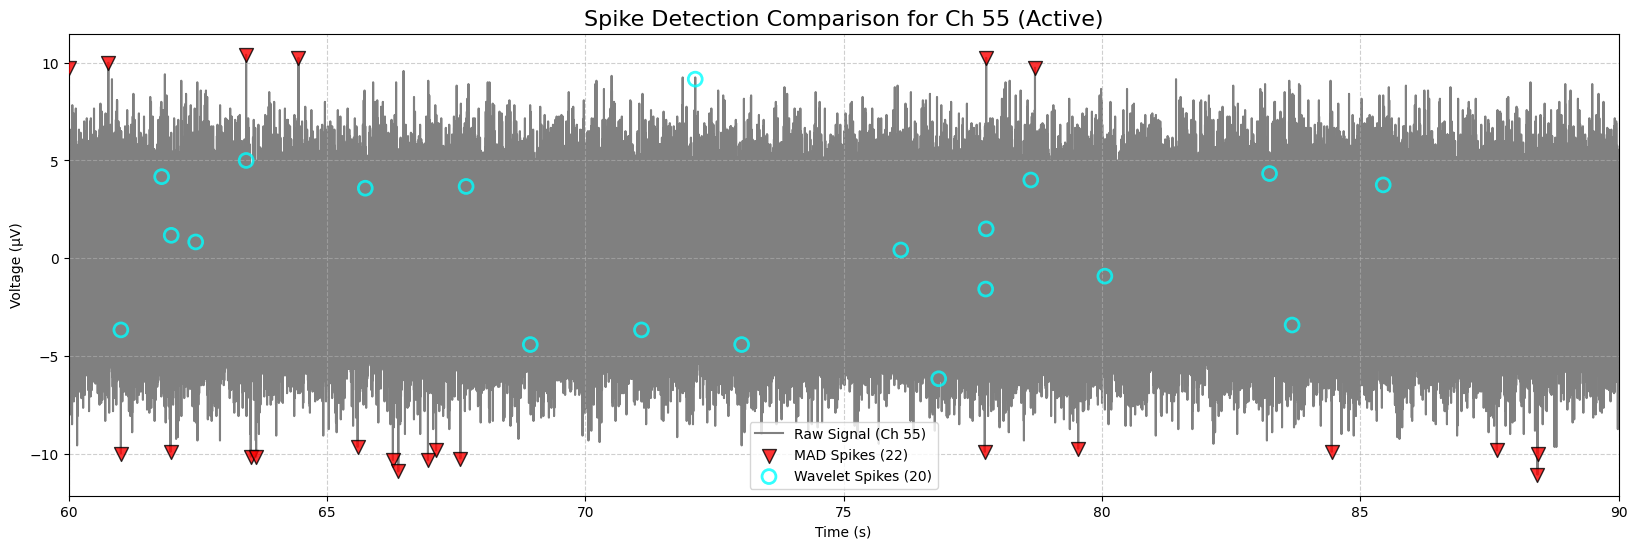

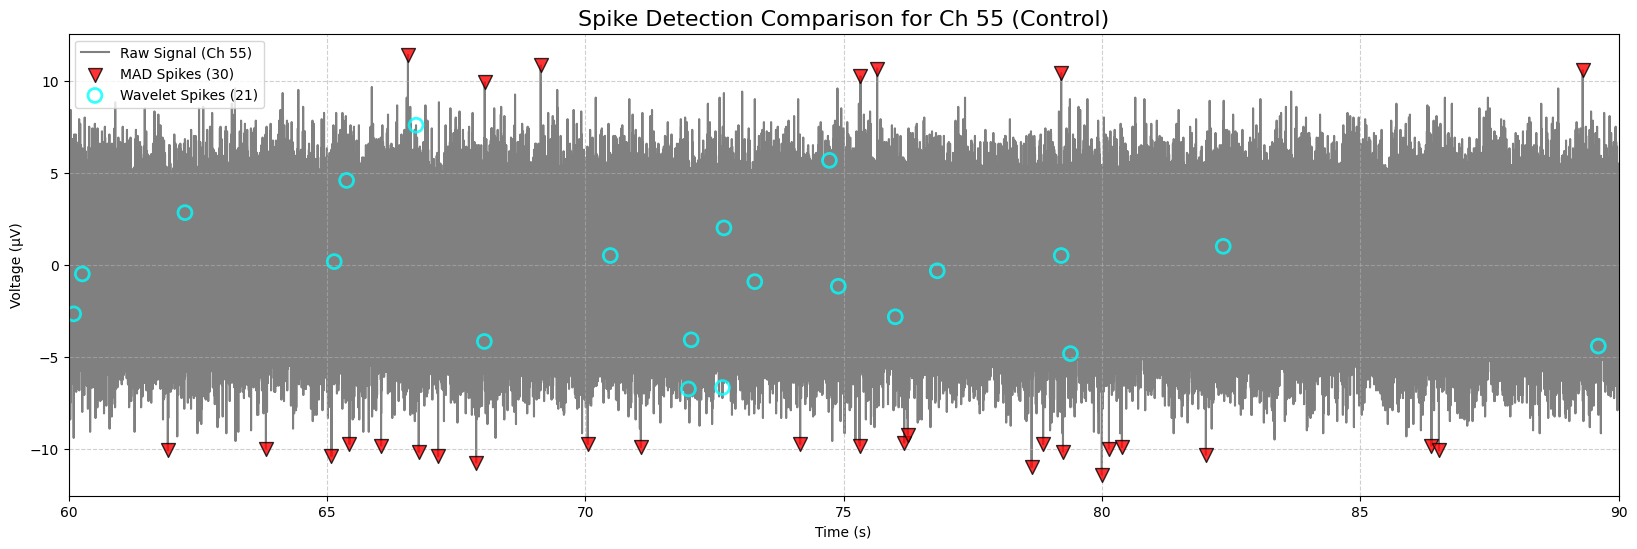

'\n    time_window = (409500, 409700)#(400000, 410000)\n    target_channel = \'Ch 55\' \n    print("\n\n" + "="*80)\n    print(f" VISUAL DEBUGGING: Raw Signal vs. Detected Spikes on {target_channel}")\n    print("="*80 + "\n")\n    plot_detection_comparison(active_analysis, target_channel, time_window)\n\n    target_channel = \'Ch 32\'\n    print("\n\n" + "="*80)\n    print(f" VISUAL DEBUGGING: Raw Signal vs. Detected Spikes on {target_channel}")\n    print("="*80 + "\n")\n    plot_detection_comparison(active_analysis, target_channel, time_window)\n\n    target_channel = \'Ch 33\'\n    print("\n\n" + "="*80)\n    print(f" VISUAL DEBUGGING: Raw Signal vs. Detected Spikes on {target_channel}")\n    print("="*80 + "\n")\n    plot_detection_comparison(active_analysis, target_channel, time_window)\n\n    time_window = (402000, 406000)\n    target_channel = \'Ch 32\'\n    print("\n\n" + "="*80)\n    print(f" VISUAL DEBUGGING: Raw Signal vs. Detected Spikes on {target_channel}")\n    print("=

In [ ]:
# Cell 6: Visual Debugging of Spike Detection
def plot_detection_comparison(analysis_obj, channel_name, time_range_s):
    if not analysis_obj or channel_name not in analysis_obj.raw_data_df.columns:
        print("Analysis object or channel not found."); return
    raw_df = analysis_obj.raw_data_df
    time_range_ms = [t * 1000 for t in time_range_s]
    time_mask = (raw_df['t'] >= time_range_ms[0]) & (raw_df['t'] <= time_range_ms[1])
    timestamps = raw_df.loc[time_mask, 't'].values
    voltages = raw_df.loc[time_mask, channel_name].values
    if len(timestamps) == 0:
        print(f"No data found in the time range {time_range_s} s."); return
    plt.figure(figsize=(20, 6))
    plt.plot(timestamps / 1000.0, voltages, color='gray', label=f'Raw Signal ({channel_name})', zorder=1)
    for method, color, marker, name in [('mad', 'red', 'v', 'MAD'), ('wavelet', 'cyan', 'o', 'Wavelet')]:
        spikes = analysis_obj.spike_results[method][channel_name]
        mask = (spikes['spike_times_ms'] >= time_range_ms[0]) & (spikes['spike_times_ms'] <= time_range_ms[1])
        spike_times = spikes['spike_times_ms'][mask]
        spike_amps = spikes['spike_amplitudes_uv'][mask]
        plt.scatter(spike_times / 1000.0, spike_amps, color=color, s=100, marker=marker,
                    label=f'{name} Spikes ({len(spike_times)})', zorder=3 if method=='mad' else 2,
                    edgecolors='k' if method=='mad' else None, alpha=0.8,
                    facecolors='none' if method=='wavelet' else color,
                    linewidths=2 if method=='wavelet' else 1)
    plt.title(f'Spike Detection Comparison for {channel_name} ({analysis_obj.sample_name})', fontsize=16)
    plt.xlabel('Time (s)'); plt.ylabel('Voltage (µV)'); plt.legend(); plt.grid(True, linestyle='--', alpha=0.6)
    plt.xlim(time_range_s); plt.show()


if control_analysis and active_analysis:
    
    print('test')
    time_window = (60, 90)#(402000, 404000)#(10000, 60000)

    target_channel = 'Ch 55' 
    plot_detection_comparison(active_analysis, target_channel, time_window)

    target_channel = 'Ch 55'
    plot_detection_comparison(control_analysis, target_channel, time_window)
'''
    time_window = (409500, 409700)#(400000, 410000)
    target_channel = 'Ch 55' 
    print("\n\n" + "="*80)
    print(f" VISUAL DEBUGGING: Raw Signal vs. Detected Spikes on {target_channel}")
    print("="*80 + "\n")
    plot_detection_comparison(active_analysis, target_channel, time_window)
    
    target_channel = 'Ch 32'
    print("\n\n" + "="*80)
    print(f" VISUAL DEBUGGING: Raw Signal vs. Detected Spikes on {target_channel}")
    print("="*80 + "\n")
    plot_detection_comparison(active_analysis, target_channel, time_window)

    target_channel = 'Ch 33'
    print("\n\n" + "="*80)
    print(f" VISUAL DEBUGGING: Raw Signal vs. Detected Spikes on {target_channel}")
    print("="*80 + "\n")
    plot_detection_comparison(active_analysis, target_channel, time_window)

    time_window = (402000, 406000)
    target_channel = 'Ch 32'
    print("\n\n" + "="*80)
    print(f" VISUAL DEBUGGING: Raw Signal vs. Detected Spikes on {target_channel}")
    print("="*80 + "\n")
    plot_detection_comparison(active_analysis, target_channel, time_window)

    target_channel = 'Ch 33'
    print("\n\n" + "="*80)
    print(f" VISUAL DEBUGGING: Raw Signal vs. Detected Spikes on {target_channel}")
    print("="*80 + "\n")
    plot_detection_comparison(active_analysis, target_channel, time_window)
    '''